# Part A1: Data Preparation

This section loads the complete MNIST dataset using `torchvision`. We combined the training and testing sets, then performed a stratified 60/20/20 split to create our training, validation, and test sets. Finally, we set up `DataLoaders` for each set to feed the data to our models in batches.

In [24]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Lambda(lambda x: torch.flatten(x))
                             ])

train_set=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set=torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_set = ConcatDataset([train_set, test_set])

targets= torch.cat([train_set.targets, test_set.targets])
indices = np.arange(len(data_set))

train_indices, temp_indices, _, temp_targets = train_test_split(
    indices, targets, test_size=0.4, stratify=targets, random_state=42)
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, temp_targets, test_size=0.5, stratify=temp_targets, random_state=42)

train_subset = Subset(data_set, train_indices)
val_subset = Subset(data_set, val_indices)
test_subset = Subset(data_set, test_indices)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_subset, batch_size=BATCH_SIZE, shuffle=False)

# Part A2: Logistic Regression (Binary)

Here, we built our first model: a "from-scratch" Logistic Regression classifier. We first filtered the data to only include digits 0 and 1. We then defined our own weights (W), bias (b), `sigmoid` function, and `binary_cross_entropy` loss. We trained the model using a manual gradient descent loop and plotted the loss and accuracy curves.

Epoch [1/10], Train Loss: 1.8741, Train Acc: 58.13%, Val Loss: 0.5961, Val Acc: 81.77%
Epoch [2/10], Train Loss: 0.4087, Train Acc: 88.59%, Val Loss: 0.2657, Val Acc: 92.32%
Epoch [3/10], Train Loss: 0.2347, Train Acc: 93.80%, Val Loss: 0.1774, Val Acc: 95.20%
Epoch [4/10], Train Loss: 0.1700, Train Acc: 95.46%, Val Loss: 0.1379, Val Acc: 96.65%
Epoch [5/10], Train Loss: 0.1357, Train Acc: 96.41%, Val Loss: 0.1156, Val Acc: 97.26%
Epoch [6/10], Train Loss: 0.1144, Train Acc: 97.00%, Val Loss: 0.1009, Val Acc: 97.46%
Epoch [7/10], Train Loss: 0.0996, Train Acc: 97.40%, Val Loss: 0.0904, Val Acc: 97.60%
Epoch [8/10], Train Loss: 0.0888, Train Acc: 97.71%, Val Loss: 0.0823, Val Acc: 97.84%
Epoch [9/10], Train Loss: 0.0804, Train Acc: 97.95%, Val Loss: 0.0759, Val Acc: 97.97%
Epoch [10/10], Train Loss: 0.0737, Train Acc: 98.05%, Val Loss: 0.0705, Val Acc: 98.11%
--- Plotting Deliverables ---


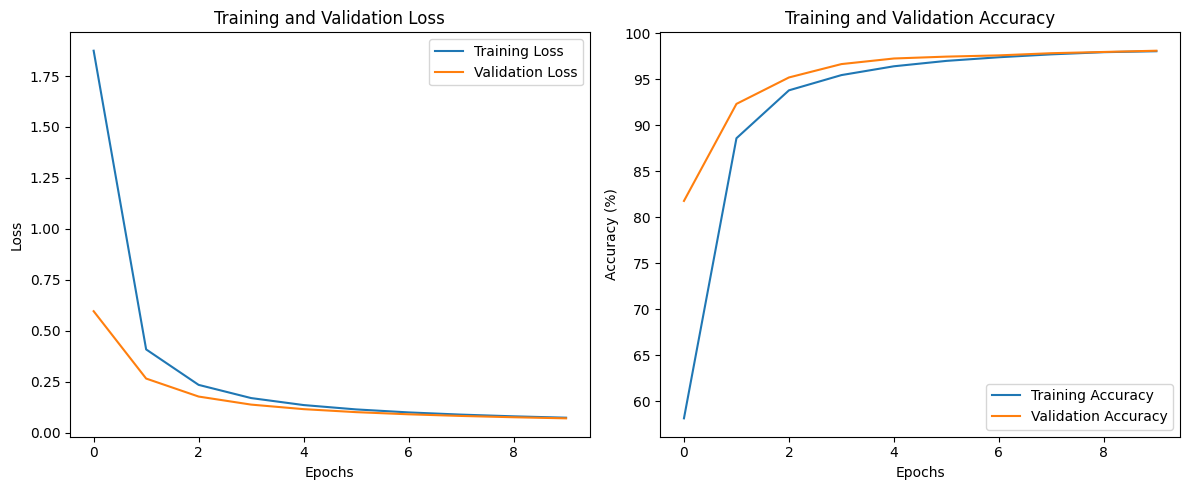

--- Final Test Set Evaluation ---
Final Test Accuracy: 97.97%


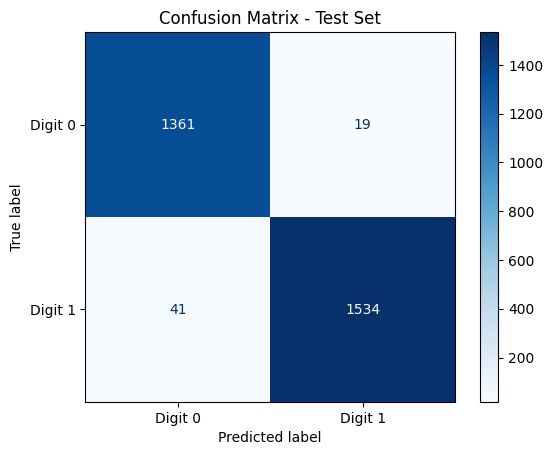

In [25]:
def filter_binary_digits(loader, digit1=0, digit2=1, shuffle_data=False):
    images_list = []
    labels_list = []
    
    for images, labels in loader:
        mask = (labels == digit1) | (labels == digit2)
        
        if mask.any():
            images_list.append(images[mask])
            new_labels = labels[mask]
            new_labels[new_labels == digit1] = 0
            new_labels[new_labels == digit2] = 1
            labels_list.append(new_labels)

    all_images = torch.cat(images_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0)
    
    all_labels = all_labels.float().view(-1, 1) 
    
    new_dataset = TensorDataset(all_images, all_labels)
    
    new_loader = DataLoader(new_dataset, batch_size=loader.batch_size, shuffle=shuffle_data)
    
    return new_loader


train_loader_01 = filter_binary_digits(train_loader, 0, 1, shuffle_data=True)
val_loader_01 = filter_binary_digits(val_loader, 0, 1, shuffle_data=False)
test_loader_01 = filter_binary_digits(test_loader, 0, 1, shuffle_data=False)



n_features = 784
n_outputs = 1

W = torch.randn(n_features, n_outputs, requires_grad=True)
b = torch.zeros(n_outputs, requires_grad=True)

learning_rate = 0.01
num_epochs = 10

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def binary_cross_entropy(y_pred, y_true):
    epsilon = 1e-7
    loss = -(y_true * torch.log(y_pred + epsilon) + (1 - y_true) * torch.log(1 - y_pred + epsilon))
    return torch.mean(loss)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for epoch in range(num_epochs):
    train_loss_epoch = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader_01:
        z = torch.matmul(images, W) + b
        y_pred = sigmoid(z)
        
        loss = binary_cross_entropy(y_pred, labels)
        
        loss.backward()
        
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad
            
            W.grad.zero_()
            b.grad.zero_()
            
        train_loss_epoch += loss.item() * images.size(0)
        predicted = (y_pred > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    val_loss_epoch = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader_01:
            z = torch.matmul(images, W) + b
            y_pred = sigmoid(z)
            
            loss = binary_cross_entropy(y_pred, labels)
            
            val_loss_epoch += loss.item() * images.size(0)
            predicted = (y_pred > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_train_loss = train_loss_epoch / total_train
    avg_val_loss = val_loss_epoch / total_val
    avg_train_acc = 100 * correct_train / total_train
    avg_val_acc = 100 * correct_val / total_val
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%')


print("--- Plotting Deliverables ---")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

print("--- Final Test Set Evaluation ---")
all_preds = []
all_true = []

with torch.no_grad():
    for images, labels in test_loader_01:
        z = torch.matmul(images, W) + b
        y_pred = sigmoid(z)
        
        predicted = (y_pred > 0.5).float()
        
        all_preds.extend(predicted.numpy())
        all_true.extend(labels.numpy())

test_accuracy = 100 * (np.array(all_preds) == np.array(all_true)).mean()
print(f'Final Test Accuracy: {test_accuracy:.2f}%')

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Digit 0', 'Digit 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

# Part A3: Softmax Regression (Multi-class)

In this part, we expanded our model to classify all 10 digits (0-9). We used the full, original `DataLoaders`. We built a new "from-scratch" Softmax Regression model, defining our own `softmax` function and `cross_entropy_loss`. After training, we plotted the results and generated a full 10x10 confusion matrix to evaluate its performance on all classes.

Starting Softmax Regression training...
Epoch [1/10], Train Loss: 7.7734, Train Acc: 15.61%, Val Loss: 5.0204, Val Acc: 27.99%
Epoch [2/10], Train Loss: 3.7002, Train Acc: 40.56%, Val Loss: 2.9088, Val Acc: 48.98%
Epoch [3/10], Train Loss: 2.4636, Train Acc: 54.83%, Val Loss: 2.1768, Val Acc: 59.21%
Epoch [4/10], Train Loss: 1.9449, Train Acc: 62.44%, Val Loss: 1.8112, Val Acc: 64.79%
Epoch [5/10], Train Loss: 1.6599, Train Acc: 67.10%, Val Loss: 1.5905, Val Acc: 68.39%
Epoch [6/10], Train Loss: 1.4781, Train Acc: 70.21%, Val Loss: 1.4430, Val Acc: 70.81%
Epoch [7/10], Train Loss: 1.3513, Train Acc: 72.53%, Val Loss: 1.3373, Val Acc: 72.73%
Epoch [8/10], Train Loss: 1.2570, Train Acc: 74.27%, Val Loss: 1.2555, Val Acc: 74.45%
Epoch [9/10], Train Loss: 1.1836, Train Acc: 75.67%, Val Loss: 1.1911, Val Acc: 75.56%
Epoch [10/10], Train Loss: 1.1243, Train Acc: 76.79%, Val Loss: 1.1385, Val Acc: 76.44%
Softmax training finished!
--- Plotting Softmax Deliverables ---


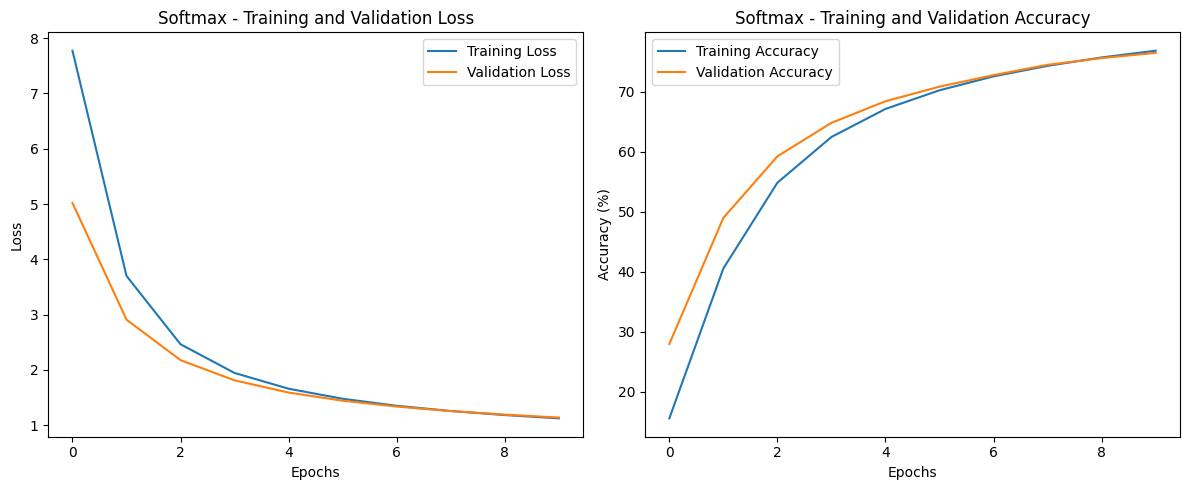

--- Final Softmax Test Set Evaluation ---
Final Softmax Test Accuracy: 76.17%

--- Confusion Matrix (Softmax) ---


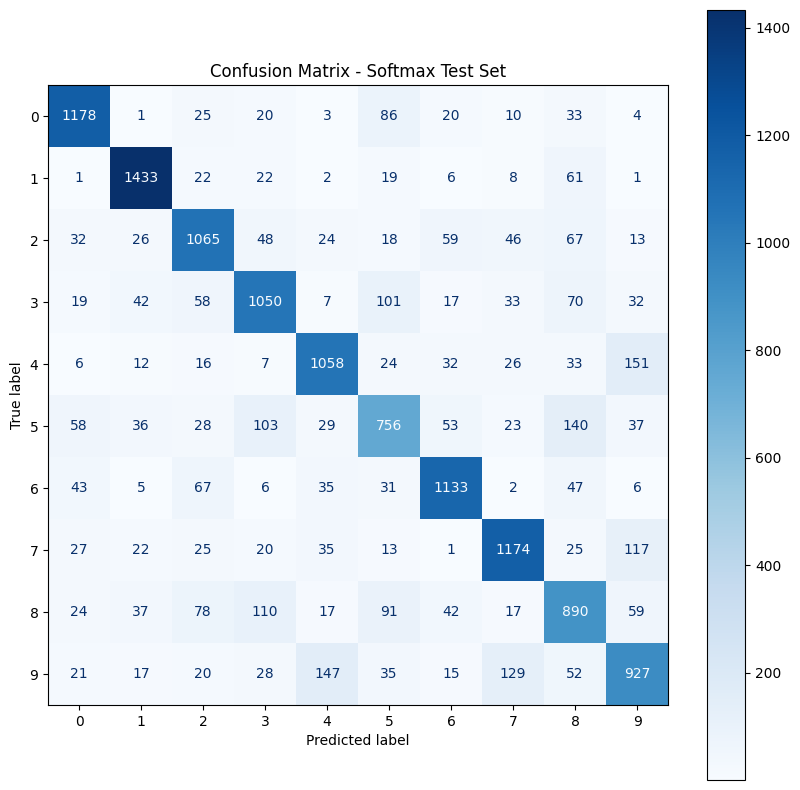


--- Per-class Accuracy Analysis (Softmax) ---
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1380
           1       0.88      0.91      0.89      1575
           2       0.76      0.76      0.76      1398
           3       0.74      0.73      0.74      1429
           4       0.78      0.78      0.78      1365
           5       0.64      0.60      0.62      1263
           6       0.82      0.82      0.82      1375
           7       0.80      0.80      0.80      1459
           8       0.63      0.65      0.64      1365
           9       0.69      0.67      0.68      1391

    accuracy                           0.76     14000
   macro avg       0.76      0.76      0.76     14000
weighted avg       0.76      0.76      0.76     14000



In [26]:
n_features = 784
n_outputs_softmax = 10

W_softmax = torch.randn(n_features, n_outputs_softmax, requires_grad=True)
b_softmax = torch.zeros(n_outputs_softmax, requires_grad=True)

learning_rate = 0.01
num_epochs = 10

def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True)[0])
    return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

def cross_entropy_loss(y_pred_softmax, y_true):
    num_samples = y_true.shape[0]
    epsilon = 1e-9
    
    correct_class_probs = y_pred_softmax[range(num_samples), y_true]
    
    loss = -torch.log(correct_class_probs + epsilon)
    
    return torch.mean(loss)

train_losses_softmax = []
val_losses_softmax = []
train_accuracies_softmax = []
val_accuracies_softmax = []

print("Starting Softmax Regression training...")

for epoch in range(num_epochs):
    train_loss_epoch = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        
        z = torch.matmul(images, W_softmax) + b_softmax
        
        y_pred = softmax(z)
        
        loss = cross_entropy_loss(y_pred, labels)
        
        loss.backward()
        
        with torch.no_grad():
            W_softmax -= learning_rate * W_softmax.grad
            b_softmax -= learning_rate * b_softmax.grad
            
            W_softmax.grad.zero_()
            b_softmax.grad.zero_()
            
        train_loss_epoch += loss.item() * images.size(0)
        
        predicted_class = torch.argmax(z, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_class == labels).sum().item()

    val_loss_epoch = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            z = torch.matmul(images, W_softmax) + b_softmax
            y_pred = softmax(z)
            
            loss = cross_entropy_loss(y_pred, labels)
            
            val_loss_epoch += loss.item() * images.size(0)
            
            predicted_class = torch.argmax(z, dim=1)
            total_val += labels.size(0)
            correct_val += (predicted_class == labels).sum().item()

    avg_train_loss = train_loss_epoch / total_train
    avg_val_loss = val_loss_epoch / total_val
    avg_train_acc = 100 * correct_train / total_train
    avg_val_acc = 100 * correct_val / total_val
    
    train_losses_softmax.append(avg_train_loss)
    val_losses_softmax.append(avg_val_loss)
    train_accuracies_softmax.append(avg_train_acc)
    val_accuracies_softmax.append(avg_val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%')

print("Softmax training finished!")

print("--- Plotting Softmax Deliverables ---")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_softmax, label='Training Loss')
plt.plot(val_losses_softmax, label='Validation Loss')
plt.title('Softmax - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_softmax, label='Training Accuracy')
plt.plot(val_accuracies_softmax, label='Validation Accuracy')
plt.title('Softmax - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

print("--- Final Softmax Test Set Evaluation ---")
all_preds_softmax = []
all_true_softmax = []

with torch.no_grad():
    for images, labels in test_loader:
        z = torch.matmul(images, W_softmax) + b_softmax
        
        predicted_class = torch.argmax(z, dim=1)
        
        all_preds_softmax.extend(predicted_class.numpy())
        all_true_softmax.extend(labels.numpy())

test_accuracy_softmax = 100 * (np.array(all_preds_softmax) == np.array(all_true_softmax)).mean()
print(f'Final Softmax Test Accuracy: {test_accuracy_softmax:.2f}%')

print("\n--- Confusion Matrix (Softmax) ---")
cm_softmax = confusion_matrix(all_true_softmax, all_preds_softmax)
disp_softmax = ConfusionMatrixDisplay(confusion_matrix=cm_softmax, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(10, 10))
disp_softmax.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix - Softmax Test Set')
plt.show()

print("\n--- Per-class Accuracy Analysis (Softmax) ---")
print(classification_report(all_true_softmax, all_preds_softmax))